In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, sys
import pandas as pd
import seaborn as sns
from scipy import stats

# paths 

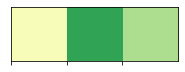

In [2]:
MPRAPATH = "/dors/capra_lab/projects/enhancer_ages/ernst16/new_data"

RE = "/dors/capra_lab/projects/enhancer_ages/landscape/results/ernst16/"

if os.path.exists(RE)== False:
    os.mkdir(RE)

colors = [ "amber", "dusty purple", "windows blue"]
colors = ["#f7fcb9", "#31a354",  "#addd8e"]
palette = sns.color_palette(colors)
sns.palplot(palette)
#%%

# Functions 

In [3]:
def formatdf(f, cell_model):

    if cell_model == "HEPG2":
        cell_model = "Hepg2"

    # assign column names
    cols = ["chr_bp", "start_bp", "end_bp", "activity",
    "chHMM_state", "tile_id",
    "chr_syn", "start_syn", "end_syn",
    "enh_id", "chr_enh", "start_enh", "end_enh",
    "seg_index", "core_remodeling", "core", "mrca"]

    # open dataframe
    df = pd.read_csv(f, sep = '\t', header = None, names = cols)

    df["cell_enh"] = df.tile_id.apply(lambda x: x.split("_")[0])


    # keep only tiles designed from cis-cell_model, only enhancer ChromHMM states
    cldf = df.loc[(df.cell_enh.str.contains(cell_model)) &
    (df.chHMM_state>=5) & (df.chHMM_state<=8)].copy()

    # assign architecture
    cldf["arch"] = "complex_core"
    cldf.loc[cldf.core == 0, "arch"] = "complex_derived"
    cldf.loc[cldf.core_remodeling == 0, "arch"] = "core"

    cldf["syn_id"] = cldf.chr_syn + ":" +cldf.start_syn.map(str) + "-" + cldf.end_syn.map(str)
    cldf["syn_len"] = cldf.end_syn - cldf.start_syn

    # add age categories
    syn_gen_bkgd_file = "/dors/capra_lab/projects/enhancer_ages/hg19_syn_gen_bkgd.tsv"
    syn_gen_bkgd= pd.read_csv(syn_gen_bkgd_file, sep = '\t') # read the file
    syn_gen_bkgd[["mrca", "mrca_2"]] = syn_gen_bkgd[["mrca", "mrca_2"]].round(3) # round the ages

    # lump Euarchontoglires w/ Boreotheria. Group is too small
    syn_gen_bkgd.loc[syn_gen_bkgd["mrca_2"] ==  0.131, "mrca_2"] = 0.152
    syn_gen_bkgd.loc[syn_gen_bkgd["taxon2"] ==  "Euarchontoglires (90)", "taxon2"] = "Boreotheria (96)"

    syn_gen_bkgd = syn_gen_bkgd[["mrca", "taxon", "mrca_2", "taxon2"]] # whittle down the df

    # round the ages
    cldf["mrca"] = cldf["mrca"].round(3)

    cldf = pd.merge(cldf, syn_gen_bkgd, how = "left", on = "mrca")
    cldf = cldf.drop(["mrca"], axis = 1).drop_duplicates()

    core_age = cldf.groupby("enh_id")["mrca_2"].max().reset_index()
    core_age.columns = ["enh_id", "core_mrca_2"]
    cldf = pd.merge(cldf, core_age, how = "left", on = "enh_id")

    # reassign core remodeling so 2 = derived segment. This is for countdf plotting purposes
    cldf.loc[cldf.core == 0, "core_remodeling"] = 2

    # limit analysis to bases with activity
    # select the enhancers where activity is greater than 1 at at least one of the bases
    active_ids = cldf.loc[cldf.activity >= 1, "enh_id"].unique() 
    active_cldf = cldf.loc[cldf.enh_id.isin(active_ids)]

    # require that syntenic blocks are at least 50bp long.
    active_cldf = cldf.loc[(cldf.activity >= 1) & (cldf.syn_len > 50)].copy() 

    return cldf, active_cldf


def custom_round(x, base=10):
    return int(base * round(float(x)/base))


def match_len(core_df, der_df, base_len):

    columns = ["syn_id", "syn_len"]
    columns_names = ["matching_ids", "matching_len"]

    core = core_df[columns].drop_duplicates()

    core.columns = columns_names
    core.matching_len = core.matching_len.astype(float).apply(lambda x: custom_round(x, base=base_len)) # round to the nearest 100bp

    der = der_df[columns].drop_duplicates()
    der.columns = columns_names

    der.matching_len = der.matching_len.astype(float).apply(lambda x: custom_round(x, base=base_len))

    lens = set(list(core.matching_len.unique()) + list(der.matching_len.unique())) # find the intersecting lengths

    match_dict = {}

    for length in lens:
        dern = der.loc[der.matching_len == length].size
        coren = core.loc[core.matching_len == length].size

        sn = min(dern, coren)

        if length > 0 and sn > 0:

            # find 100 matched enhancer samples

            der_ids = der.loc[der.matching_len == length].sample(n = sn, replace = True) # sample w/ replacement
            core_ids = core.loc[core.matching_len == length].sample(n = sn, replace = True) # sample w/ replacement
            balanced = pd.concat([core_ids, der_ids])
            match_dict[sn] = balanced

    final_matched_id = pd.concat(match_dict.values())

    return final_matched_id.matching_ids.unique()

def make_empty_dict(df):
    # for when i need an empty dictionary with a complete set of architectures and values
    emptydf_dict = {}
    val = 0 # unique identifier
    for mrca_2 in df.mrca_2.unique():
        for arch in df.core_remodeling.unique():

            emptydf = pd.DataFrame({ "mrca_2":[mrca_2], "core_remodeling":[arch],})
            emptydf_dict[val] = emptydf
            val+=1
    empty = pd.concat(emptydf_dict.values())
    return empty

def plot_activity(x, y, df, outf, cell_model):


    order = ["core", "complex_core", "complex_derived"]
    data = df

    fig, ax = plt.subplots(figsize = (6,6))
    sns.set("poster")
    sns.set_style("white")
    #splot = sns.barplot(x = x, y = y, data = data,  order = order, palette = palette)
    splot = sns.boxplot(x = x, y = y, data = data,  order = order, palette = palette, showfliers = False)
    ax.set(
        #ylim = (0,0.015), 
        title = cell_model)
    #showfliers = False, notch = True
    height_adjust = 0.001

    groupby_cols, groupby_val = ["core_remodeling"], "counts"
    countdf = get_counts(df, groupby_cols, groupby_val)

    plot_annotate_counts(splot, countdf, groupby_val, height_adjust)

    counts = df.groupby("arch")[y].count()
    means = df.groupby("arch")[y].median()
    derived_activity = df.loc[df.arch == "complex_derived", y]
    complex_activity = df.loc[df.arch == "complex_core", y]

    stat, p = stats.mannwhitneyu(derived_activity, complex_activity)
    xticklabs = ["core", "der\ncore", "der\nderived"]

    ax.set(
    xticklabels = xticklabs,
    xlabel = "core v. der mwu p = %s\n%s" % (p, means),
    ylabel = "predicted activity (bp)",
    title = cell_model
    )


    plt.savefig(outf, bbox_inches = "tight")


def get_act_freq(info_df, active_df, cell_model, matching):

    n_total = info_df.groupby("arch")["enh_id"].count().reset_index()
    n_total.columns = ["arch", "total_bp_count"]
    n_active = active_df.groupby("arch")["enh_id"].count().reset_index()
    n_active.columns = ["arch", "active_bp_count"]

    freq = pd.merge(n_total, n_active)
    freq["freq"] = freq.active_bp_count.divide(freq.total_bp_count)
    outf = f"{RE}{cell_model}_{matching}_active_base_freq.tsv"
    freq.to_csv(outf, sep = '\t', header = None)
    return freq


def plot_dist(active_df, variable):
    fig, ax = plt.subplots()
    for arch in active_df.arch.unique():
        test = active_df.loc[active_df.arch == arch, variable]
        sns.kdeplot(test, label = arch)
    ax.legend()


def get_counts(df, groupby_cols, groupby_val):

    counts = df.groupby(groupby_cols)[groupby_val].sum().reset_index()

    if "mrca_2" in groupby_cols and "core_remodeling" in groupby_cols:

        empty = make_empty_dict(info_df) # make an empty df to fill architectures w/ no counts
        counts = pd.merge(empty, counts, how = "left", on = groupby_cols).fillna(0)

    elif "core_mrca_2" in groupby_cols and "core_remodeling" in groupby_cols:

        empty = make_empty_dict(info_df) # make an empty df to fill architectures w/ no counts
        empty.columns = ["core_mrca_2", "core_remodeling"]
        counts = pd.merge(empty, counts, how = "left", on = groupby_cols).fillna(0)
        #counts = pd.concat([counts, empty]) # concat the dataframe

    # change count data to int
    counts[groupby_val] = counts[groupby_val].astype(int)

    # sort and reset the index. Seaborn plots by index value.
    counts = counts.sort_values(by = groupby_cols).reset_index()

    # drop the index column.
    counts = counts.drop(["index"], axis = 1)

    return counts


def plot_annotate_counts(splot, counts_df, groupby_val, height_adjust):

    # annotate plot with counts
    for n, p in enumerate(splot.patches):

        value = counts_df.iloc[n][groupby_val].astype(int)
        #print(n, p, value)
        if height_adjust == 0:
            height_adjust = (p.get_height()-0.03)


        splot.annotate(value,
                       (p.get_x() + p.get_width() / 2.,height_adjust),
                       ha = 'center', va = 'baseline',
                       size=15,
                       rotation = 90,
                       color = "k",
                       xytext = (0, 1),
                       textcoords = 'offset points'
                       )


def plot_stratified_age(act_df, outf, x, cell_model):

    y = "activity"
    hue = "arch"
    data = act_df
    order = ["core", "complex_core", "complex_derived"]


    fig, ax = plt.subplots(figsize = (6,6))
    #fig, ax = plt.subplots()
    sns.set("poster")

    splot = sns.barplot(x = x,
    y = y,
    data = data,
    hue = hue,
    hue_order = order,
    palette = palette
    )
    labs = ["Homo", "Prim", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Vert"]
    ax.set(
        #ylim = (0,0.02),
        title = cell_model)
    ax.set_xticklabels(labs, rotation = 90)
    ax.invert_xaxis()
    height_adjust = 0.001

    groupby_cols, groupby_val = ["core_remodeling", x], "counts"
    countdf = get_counts(act_df, groupby_cols, groupby_val)

    plot_annotate_counts(splot, countdf, groupby_val, height_adjust)
    ax.legend(bbox_to_anchor = (1,1))

    plt.savefig(outf, bbox_inches = "tight")
    return countdf


def plot_distplot(df, cell_model, matching):
    sns.distplot(df.loc[df.arch == "complex_core", "syn_len"], label = "core")
    sns.distplot(df.loc[df.arch == "complex_derived", "syn_len"], label = "der")
    plt.legend()
    outf =  f"{RE}{cell_model}_ernst_active_bases_dist_{matching}.pdf"
    plt.savefig(outf, bbox_inches = "tight")

# create matched sets of core/der syntenic lengths 

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility

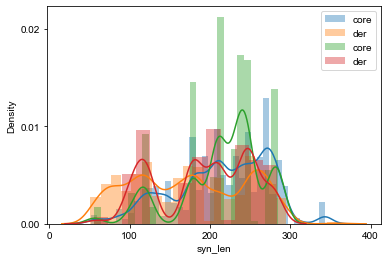

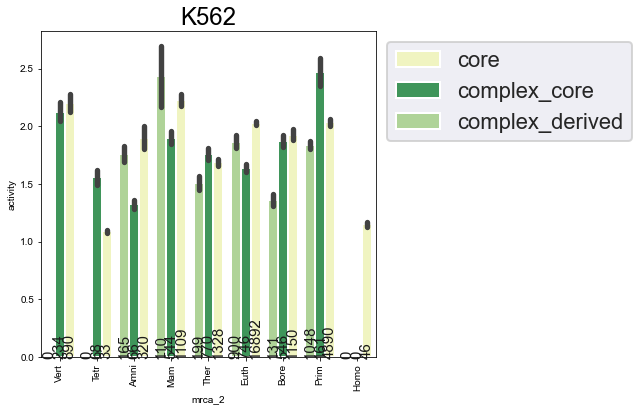

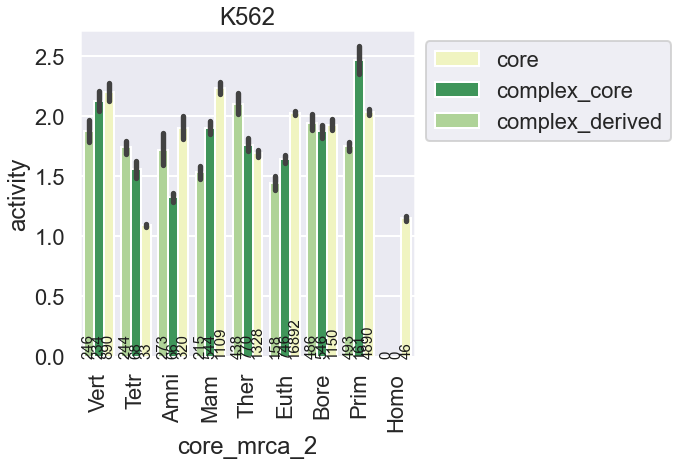

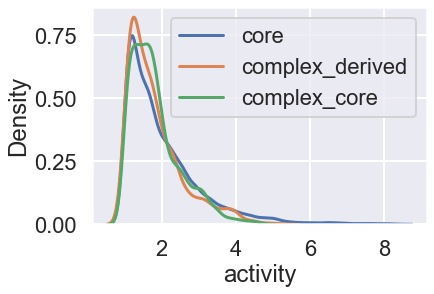

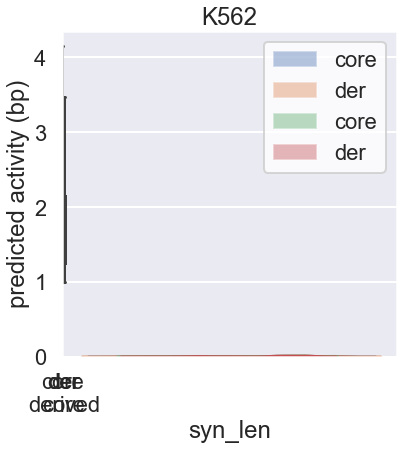

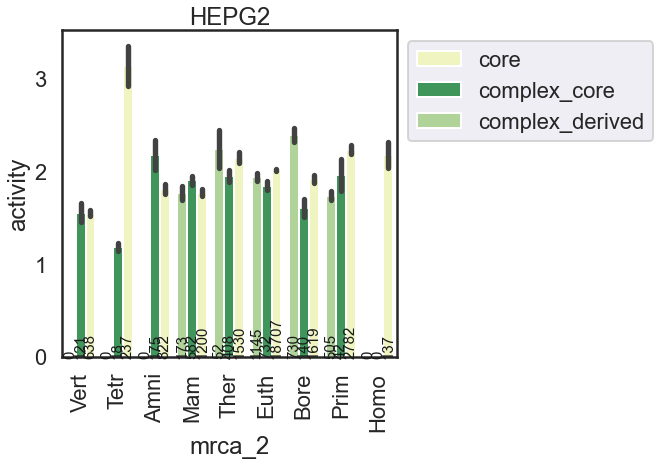

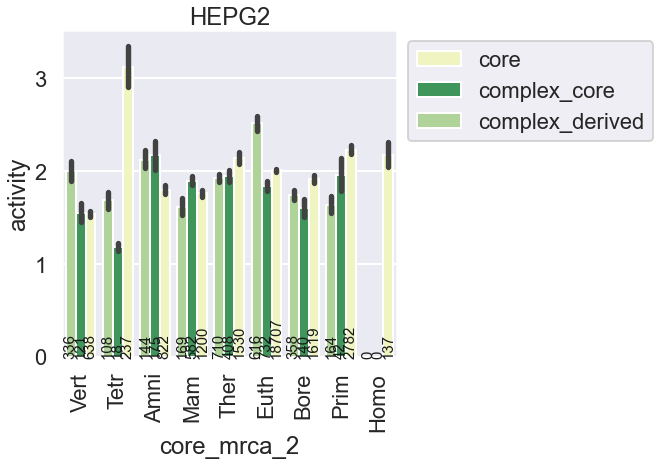

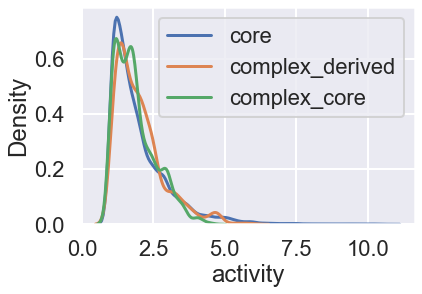

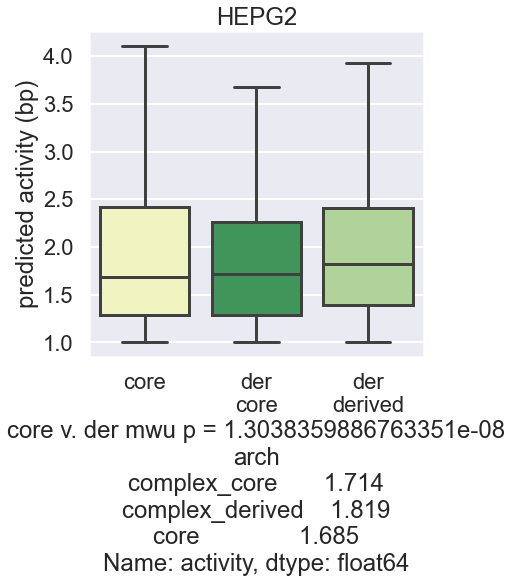

In [4]:
#%%
CELL_MODELS = ["K562", "HEPG2"]
BASE_LEN = 10  # for matching on a 10bp window

results_dict = {}
for CELL_MODEL in CELL_MODELS:
    MPRAFILE = CELL_MODEL + "_combined_base_tiles_ages.bed"

    MPRAF = os.path.join(MPRAPATH, MPRAFILE)

    info_df, act_df = formatdf(MPRAF, CELL_MODEL)


    # stratify activity df by architecture.
    core_df = act_df.loc[act_df.arch == "complex_core"]
    der_df = act_df.loc[act_df.arch == "complex_derived"]
    sim_ids = act_df.loc[act_df.arch == "core", "syn_id"].unique()

    # match core and derived syntenic blocks based on similar lengths
    matched_ids = match_len(core_df, der_df, BASE_LEN)

    # cannot match core and simple or derived and simple because architecture def.
    # simple is full length of insert. Could randomly sample n number of bases.

    matched_ids = list(matched_ids) + list(sim_ids)

    matched_act = act_df.loc[act_df["syn_id"].isin(matched_ids)]
    matched_act["counts"] = 1

    # plot length distributions
    MATCHING = "raw_lens"
    plot_distplot(act_df, CELL_MODEL, MATCHING)

    # how many active arch bases are there?
    freq_ = get_act_freq(info_df, act_df, CELL_MODEL, MATCHING)


    MATCHING = "matched_lens"
    plot_distplot(matched_act, CELL_MODEL, MATCHING)

    # how many active arch bases are there?
    freq_ = get_act_freq(info_df, act_df, CELL_MODEL, MATCHING)


    # plot activity stratified by age

    outf =f"{RE}{CELL_MODEL}_ernst_active_bases_dist_mrca2_len_matched.pdf"
    x = "mrca_2"
    plot_stratified_age(matched_act, outf, x, CELL_MODEL)

    # plot activity based on core age, stratified by core age
    outf = f"{RE}{CELL_MODEL}_ernst_active_bases_dist_core_mrca2_len_matched.pdf"
    x = "core_mrca_2"
    plot_stratified_age(matched_act, outf, x, CELL_MODEL)

    plot_dist(matched_act, "activity")


    # plot summarized results
    x = "arch"
    y = "activity"
    outf = f"{RE}{CELL_MODEL}_ernst_active_bases_dist_mrca2_len_matched.pdf"
    plot_activity(x, y, matched_act, outf, CELL_MODEL)


    results_dict[CELL_MODEL] = [info_df, act_df, matched_act, freq_]

# set fonts

In [5]:
#%%
font_paths = mpl.font_manager.findSystemFonts()
font_objects = mpl.font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)
#%%

['Noto Serif Georgian', 'Noto Serif Armenian', 'Lato', 'Sourcing Code Pro', 'Robotization Mono', 'Noto Serif Georgian', 'Vollkorn', 'Sourcing Code Pro', 'IBM Plex Mono', 'Vollkorn', 'Noto Serif Thai', 'Noto Serif', 'Noto Serif Tamil', 'Nimbus Mono PS', 'Cousine', 'Catamaran', 'Nimbus Sans Narrow', 'Kawkab Mono', 'Noto Sans Georgian', 'DejaVu Sans', 'DejaVu Sans Mono For Conso1as', 'Noto Sans Armenian', 'Noto Nastaliq Urdu', 'Sourcing Code Pro', 'Noto Serif', 'Cantarell', 'Sourcing Code Pro', 'Nimbus Sans Narrow', 'Libertinus Serif', 'Noto Sans Bengali', 'IBM Plex Mono', 'XITS Two Math', 'Sourcing Code Pro', 'Source Sans Pro', 'Noto Sans Tamil', 'Noto Sans Thai', 'Symbola', 'Lato', 'DejaVu Sans Mono', 'Source Code Pro', 'Source Serif Pro', 'Noto Sans Georgian', 'Noto Serif', 'Noto Sans Bengali', 'Noto Serif', 'Noto Sans', 'Noto Sans Hebrew', 'Noto Sans Devanagari', 'Noto Sans Armenian', 'Sourcing Sans Pro', 'Source Code Pro', 'Noto Serif Tamil', 'Noto Serif Armenian', 'URW Bookman', 'So

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# No matching

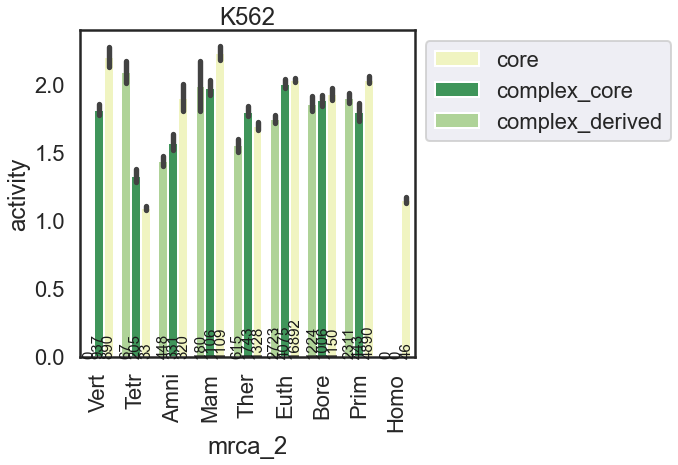

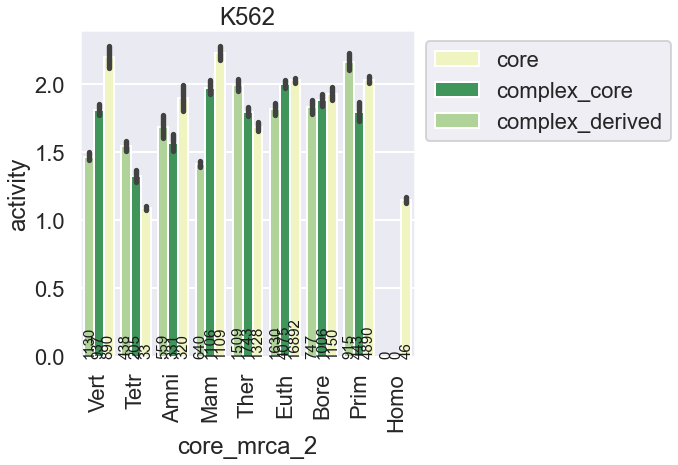

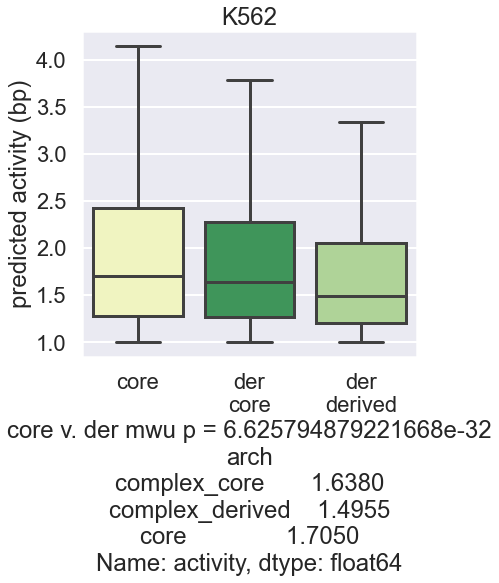

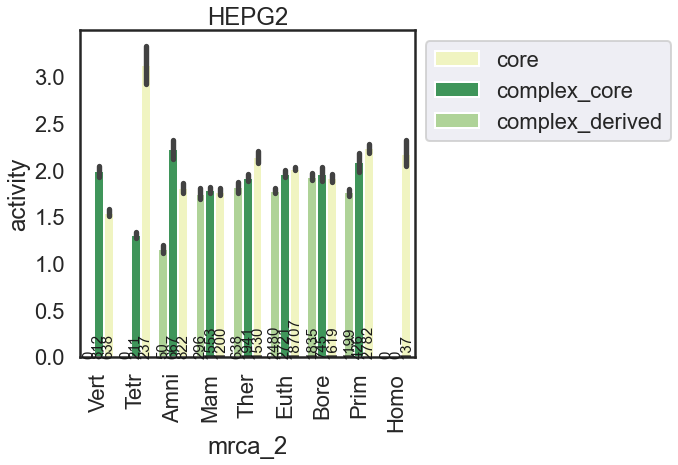

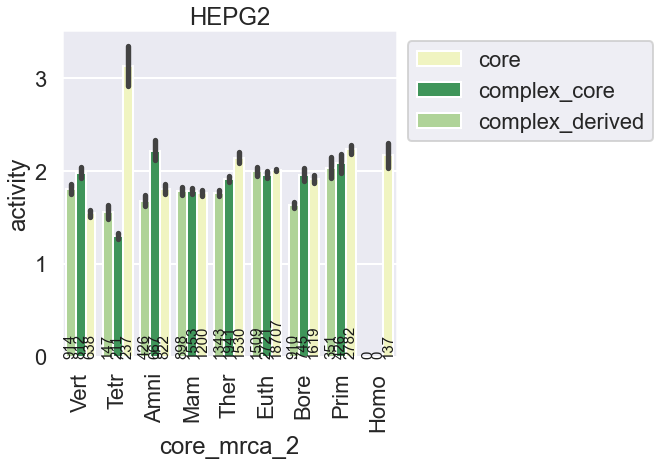

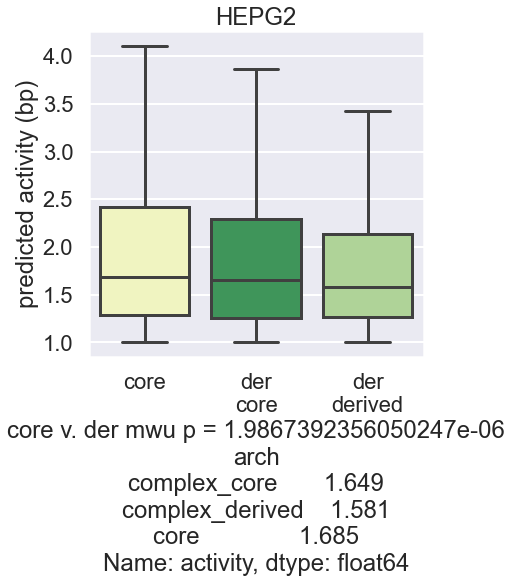

In [7]:
CELL_MODELS = ["K562", "HEPG2"]

for CELL_MODEL in CELL_MODELS:
    MPRAFILE = CELL_MODEL + "_combined_base_tiles_ages.bed"

    MPRAF = os.path.join(MPRAPATH, MPRAFILE)

    info_df, act_df = formatdf(MPRAF, CELL_MODEL)

    # stratify activity df by architecture.
    core_df = act_df.loc[act_df.arch == "complex_core"]
    der_df = act_df.loc[act_df.arch == "complex_derived"]
    sim_ids = act_df.loc[act_df.arch == "core", "syn_id"].unique()

    # match core and derived syntenic blocks based on similar lengths

    #matched_ids = match_len(core_df, der_df, BASE_LEN)

    # cannot match core and simple or derived and simple because architecture def.
    # simple is full length of insert. Could randomly sample n number of bases.

    #matched_ids = list(matched_ids) + list(sim_ids)

    #matched_act = act_df.loc[act_df["syn_id"].isin(matched_ids)]
    matched_act = act_df.copy()
    matched_act["counts"] = 1

    # plot length distributions
    MATCHING = "raw_lens"
    #plot_distplot(act_df, CELL_MODEL, MATCHING)

    # how many active arch bases are there?
    freq_ = get_act_freq(info_df, act_df, CELL_MODEL, MATCHING)


    # plot activity stratified by age

    outf =f"{RE}{CELL_MODEL}_ernst_active_bases_dist_mrca2_all.pdf"
    x = "mrca_2"
    plot_stratified_age(matched_act, outf, x, CELL_MODEL)

    # plot activity based on core age, stratified by core age
    outf = f"{RE}{CELL_MODEL}_ernst_active_bases_dist_core_mrca2_all.pdf"
    x = "core_mrca_2"
    plot_stratified_age(matched_act, outf, x, CELL_MODEL)

    #plot_dist(matched_act, "activity")

    
    # plot summarized results
    x = "arch"
    y = "activity"
    outf = f"{RE}{CELL_MODEL}_ernst_active_bases_dist_mrca2_all.pdf"
    plot_activity(x, y, matched_act, outf, CELL_MODEL)
    


    #results_dict[CELL_MODEL] = [info_df, act_df, matched_act, freq_]
    break

In [ ]:
#%%
hepg2_active_df.head()
cols = ["enh_id", "core", "arch", "syn_len", "mrca_2", "taxon2", "core_mrca_2", "activity"]
cores = hepg2_active_df.loc[hepg2_active_df.arch == "complex_core", cols].drop_duplicates()
ders = hepg2_active_df.loc[hepg2_active_df.arch == "complex_derived", cols].drop_duplicates()

arch = pd.merge(cores, ders, how = "outer", on = "enh_id")
arch.shape
arch = arch.dropna()
arch.shape
arch.head()
x = "activity_x"
y = "activity_y"
data = arch
sns.jointplot(x = x, y = y, data = data)
#%%

from sklearn.linear_model import LinearRegression

# does core activity predict derived activity?
X = np.array(arch["activity_x"]).reshape(-1, 1)
y = np.array(arch["activity_y"]).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 0.00963961057383722 kind of

reg.coef_ #0.13432273

# does derived activity predict core activity?
# does core activity predict derived activity?
y = np.array(arch["activity_x"]).reshape(-1, 1)
x = np.array(arch["activity_y"]).reshape(-1, 1)
x
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 0.00963961057383722 kind of

reg.coef_ #0.13432273